# Solving N-Queens Problem with Genetic, Bee, and Ant Algorithms

In [1]:
from deap import base, creator, tools
import random
from array import array
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import elitism
import queens

In [2]:
# problem constants:
NUM_OF_QUEENS = 16

# Genetic Algorithm constants:
POPULATION_SIZE = 500
MAX_GENERATIONS = 100
HALL_OF_FAME_SIZE = 30
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual

# set the random seed for repeatable results
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# create the desired N-
nQueens = queens.NQueensProblem(NUM_OF_QUEENS)

In [3]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list of integers:
creator.create("Individual", array, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices:
toolbox.register("randomOrder", random.sample, range(len(nQueens)), len(nQueens))

# create the individual creation operator to fill up an Individual instance with shuffled indices:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

# create the population creation operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation - compute the total distance of the list of cities represented by indices:
def getViolationsCount(individual):
    return nQueens.getViolationsCount(individual),  # return a tuple


toolbox.register("evaluate", getViolationsCount)


# Genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=2.0/len(nQueens))
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(nQueens))

In [4]:
def plot_chessboard(best_solution: list[int]) -> None:
    # plot best solution:
    sns.set_style("whitegrid", {'axes.grid' : False})
    nQueens.plotBoard(best_solution)
    plt.show()

# Genetic Algorithm

gen	nevals	min	avg   
0  	500   	3  	10.406
1  	419   	2  	9.016 
2  	449   	2  	8.396 
3  	406   	2  	7.944 
4  	430   	2  	7.434 
5  	430   	2  	6.96  
6  	438   	2  	6.87  
7  	441   	2  	6.818 
8  	427   	2  	6.79  
9  	419   	1  	6.696 
10 	440   	1  	6.776 
11 	422   	1  	6.656 
12 	433   	1  	6.588 
13 	434   	1  	6.418 
14 	426   	1  	6.116 
15 	421   	1  	5.998 
16 	430   	1  	6.158 
17 	438   	1  	6.082 
18 	416   	1  	6.046 
19 	427   	1  	5.986 
20 	424   	1  	5.562 
21 	415   	1  	5.656 
22 	435   	1  	5.682 
23 	419   	1  	5.64  
24 	439   	1  	5.174 
25 	427   	1  	5.076 
26 	433   	1  	4.978 
27 	425   	1  	4.712 
28 	416   	1  	4.452 
29 	405   	1  	3.868 
30 	414   	0  	3.494 
31 	419   	0  	2.876 
32 	426   	0  	2.72  
33 	423   	0  	2.526 
34 	422   	0  	2.282 
35 	410   	0  	2.136 
36 	421   	0  	2.02  
37 	437   	0  	1.744 
38 	418   	0  	1.83  
39 	434   	0  	1.694 
40 	434   	0  	1.482 
41 	430   	0  	1.428 
42 	431   	0  	1.336 
43 	432   	0  	1.402 
44 	433   

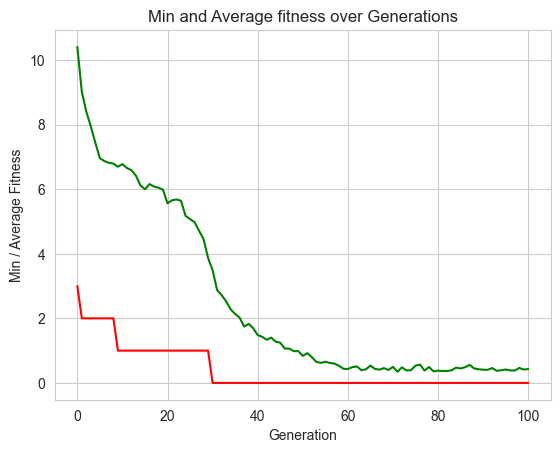

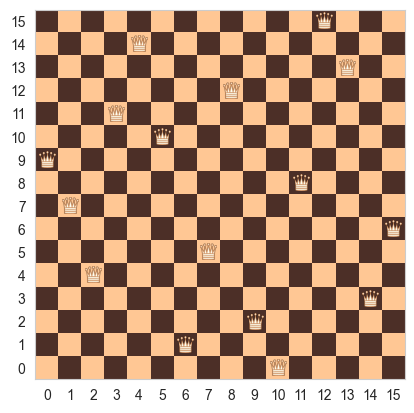

In [5]:
# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                            ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print hall of fame members info:
print("- Best solutions are:")
for i in range(HALL_OF_FAME_SIZE):
    print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

# plot statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(1)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red', label='min')
plt.plot(meanFitnessValues, color='green', label='mean')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')
plt.show()

plot_chessboard(hof.items[0])

# Artificial Bee Colony algorithm

In [ ]:
def neighborhood(ind):
    """Generate a neighbor solution by swapping two random indices in the individual."""
    a, b = random.sample(range(len(ind)), 2)
    neighbor = ind[:]
    neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
    return neighbor

def artificial_bee_colony(fitness_evaluator, pop_size: int, max_cycles: int, limit: int) -> tuple[list, int, list]:
    """ Artificial Bee Colony algorithm for N-Queens problem.
    Args:
        fitness_evaluator: A function that evaluates the fitness of an individual.
        pop_size: The number of artificial bees in the population.
        max_cycles: Number of iterations to run the algorithm.
        limit: The number of cycles a bee can go without finding a better solution before becoming a scout.
    Returns:
        tuple: Best solution, best fitness value, and history of best fitness values.
    """
    def f_min(bee):
        return fitness_evaluator(bee)[0]
    
    # Each bee holds a solution and a trial counter
    bees = [toolbox.individualCreator() for _ in range(pop_size)]
    fitness = [f_min(bee) for bee in bees]
    trials = [0]*pop_size

    best = min(zip(bees, fitness), key=lambda x: x[1])
    history = []

    for _ in range(max_cycles):
        # Employed bees phase
        for i in range(pop_size):
            neigh = neighborhood(bees[i])
            fit = f_min(neigh)
            if fit < fitness[i]:
                bees[i], fitness[i] = neigh, fit
                trials[i] = 0
                if fit < best[1]:
                    best = (neigh, fit)
            else:
                trials[i] += 1

        # Calculate selection probabilities for onlookers
        max_fit = max(fitness)
        probs = [ (max_fit - f + 1e-6) for f in fitness ]
        probs = [p/sum(probs) for p in probs]

        # Onlooker bees phase
        for _ in range(pop_size):
            i = random.choices(range(pop_size), probs)[0]
            neigh = neighborhood(bees[i])
            fit = f_min(neigh)
            if fit < fitness[i]:
                bees[i], fitness[i], trials[i] = neigh, fit, 0
                if fit < best[1]:
                    best = (neigh, fit)
            else:
                trials[i] += 1

        # Scout bees phase
        for i in range(pop_size):
            if trials[i] > limit:
                bees[i] = toolbox.individualCreator()
                fitness[i] = f_min(bees[i])
                trials[i] = 0
        history.append(best[1])

    return best[0], best[1], history

ABC Best Value: 0
ABC Best Solution array('i', [11, 7, 3, 0, 2, 13, 8, 10, 1, 14, 5, 15, 12, 9, 6, 4])


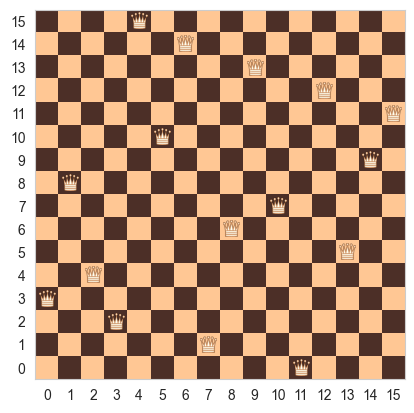

In [ ]:
abc_sol, abc_val, abc_hist = artificial_bee_colony(getViolationsCount, pop_size=POPULATION_SIZE//3, max_cycles=50, limit=MAX_GENERATIONS)
print("ABC Best Value:", abc_val)
print("ABC Best Solution", abc_sol)
plot_chessboard(abc_sol)

# Ant Colony Optimization algorithm

In [ ]:
def ant_colony_optimization(n_queens: int, fitness_evaluator, pop_size: int, max_cycles: int, alpha=1.0, beta=2.0, rho=0.1, Q=1.0) -> tuple[list, int, list]:
    """ Ant Colony Optimization for N-Queens problem.
    Args:
        n_queens (int): Number of queens (and board size).
        fitness_evaluator: Function to evaluate the fitness of a solution.
        pop_size (int): Number of artificial ants to generate.
        max_cycles (int): Number of iterations to run the algorithm.
        alpha (float): Influence of the pheromone level (tau) in selecting the next chessboard square (≥ 0).
        beta (float): Influence of the influence of the cost (eta) for selecting the next chessboard square (≥ 0).
        rho (float): Pheromone evaporation rate (between 0 and 1).
        Q (float): Pheromone deposit constant.
    Returns:
        tuple: Best solution, best fitness value, and history of best fitness values.
    """
    # Initial pheromone level τ matrix
    tau = np.ones((n_queens, n_queens))
    # heuristic η matrix, cost of placing a queen in a row of a column
    eta = np.ones((n_queens, n_queens))

    best_solution = None
    best_value = float('inf')  # (+) for minimization; (-) for maximizing
    history = []

    for _ in range(max_cycles):
        all_solutions = []
        all_fitness = []

        for _ in range(pop_size):
            solution = []
            available_rows = set(range(n_queens))

            # Calculating the chessboard squares attractiveness and probabilities over available rows
            for col in range(n_queens):
                weights = []
                for row in available_rows:
                    weights.append((tau[col, row]**alpha) * (eta[col, row]**beta))
                total = sum(weights)
                probs = [w/total for w in weights]
                chosen = random.choices(list(available_rows), probs)[0]
                solution.append(chosen)
                available_rows.remove(chosen)
            fit = fitness_evaluator(solution)[0]
            all_solutions.append(solution)
            all_fitness.append(fit)

            # Update best solution
            if fit < best_value:
                best_value = fit
                best_solution = solution.copy()

        # Evaporate
        tau *= (1 - rho)

        # Deposit pheromone: only best ant (or all)
        for sol, fit in zip(all_solutions, all_fitness):
            deposit = Q / (1 + fit)
            for col, row in enumerate(sol):
                tau[col, row] += deposit

        history.append(best_value)
    return best_solution, best_value, history

ACO best solution: [2, 7, 11, 6, 15, 9, 14, 0, 8, 1, 5, 12, 10, 4, 13, 3]
ACO best value: 0


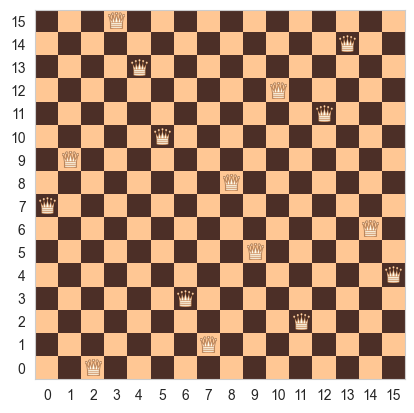

In [ ]:
aco_sol, aco_val, aco_hist = ant_colony_optimization(NUM_OF_QUEENS, getViolationsCount, pop_size=POPULATION_SIZE*2, max_cycles=MAX_GENERATIONS*2)
print("ACO best solution:", aco_sol)
print("ACO best value:", aco_val)
plot_chessboard(aco_sol)

# Ants vs Bees

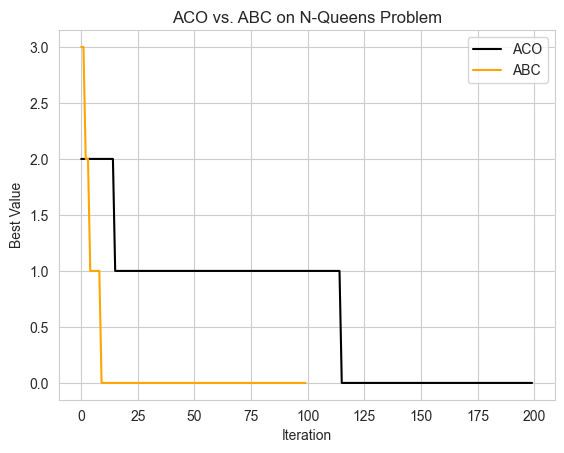

In [36]:
sns.set_style("whitegrid")
plt.plot(aco_hist, color='black', label='ACO')
plt.plot(abc_hist, color='orange', label='ABC')
plt.xlabel('Iteration')
plt.ylabel('Best Value')
plt.title('ACO vs. ABC on N-Queens Problem')
plt.legend()
plt.show()